In [2]:
import RNA
import numpy as np

import subprocess
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import SVG, display
from collections import Counter
from collections import defaultdict

import difflib
import sys
import os
import random
import string
import time

# from helper import print_moves

import pandas as pd

sys.path.append('../')
from pretty_print_path import print_moves
import findpath_librna
import findpath


In [9]:
def find_moves(s_ptable, t_ptable):
    """
    generator function, yields possible structures 1 move away
    from the original structure by finding fitting i and j with
    RNA pair and loop tables
    s_ptable: current ptable
    t_ptable: s2 end ptable
    """
    # loop table
    ls = RNA.loopidx_from_ptable(s_ptable)

    for i in range(len(s_ptable)):
        if i == 0:
            continue

        if s_ptable[i] == 0 and t_ptable[i] > i:
            j = t_ptable[i]
            # found j has to be empty and currently on the same loop as i
            if s_ptable[j] == 0 and ls[i] == ls[j]:
                yield i, j
        # test for bp removal: i has to be paired with a different j in s2
        j = s_ptable[i]
        # dont remove things which are present in s2
        if s_ptable[i] > i and s_ptable[i] != s_ptable[j] and\
                s_ptable[i] != t_ptable[i] and s_ptable[j] != t_ptable[j]:
            yield -i, -j




def process(sequence, s1, s2):

    s = s1
    pt2 = list(RNA.ptable(s2))
    fc = RNA.fold_compound(sequence)

    for e, (a,b, en) in enumerate(path):
        if (a,b) == (0,0):
            continue  

        # check where we can go, compare with our best move. 
        pt = list(RNA.ptable(s))

        # check available moves, save them, sort them    
        avail_moves = []
        found_pos = None

        for pos, (i,j) in enumerate(find_moves(pt, pt2)):    
            next_en = fc.eval_move_pt(pt, i, j)
            # mark where we found our move

            found = (i,j) == (a,b)
            avail_moves.append((i, j, next_en, found))


        avail_moves.sort(key=lambda x: x[2])
        found_list = [x[3] for x in avail_moves]

        # find where our move is after sorting
        found_pos = found_list.index(True)
        rel_pos = found_pos * 1.0 / len(found_list)

        print (e, a,b, 'found at pos:', found_pos, 'of', len(avail_moves), ':',  1-rel_pos)
        # print (avail_moves, a, b)

        
        # if e==63:
        #     print (avail_moves)

        # update s for the next iteration
        
        if a > 0:
            s = s[:a-1] + "(" + s[a:b-1] + ")" + s[b:]
        if a < 0:
            s = s[:-a-1] + "." + s[-a:-b-1] + "." + s[-b:]
        # if not en:
        #     en = round(fc.eval_structure(s), 2)


In [3]:
# find a sequence + structure pair as example (good sw-multiplier scaling)

sys.path.append('./indirect')
import helper
target_count = 1
x = 100
min_bp_dist = 20

def detect_local_minimum(fc, structure):
    # perform gradient walk from sample to determine direct local minimum
    pt = RNA.IntVector(RNA.ptable(structure))
    fc.path(pt, 0, RNA.PATH_DEFAULT | RNA.PATH_NO_TRANSITION_OUTPUT)
    return RNA.db_from_ptable(list(pt))

# check confirmations for merging
s_list = []
while (len(s_list) < target_count):

    # RNAsubopt wrapper
    sequence, s1, s2 = helper.generate_structures(x)

    # overwrite s1 s2 to local minimum
    fc = RNA.fold_compound(sequence)
    s1 = detect_local_minimum(fc, s1)
    s2 = detect_local_minimum(fc, s2)
    bp_dist = RNA.bp_distance(s1, s2)

    if bp_dist < min_bp_dist:
        continue



    sws = [0.5, 1, 2, 4, 6]
    results = []
    for sw in sws:
        fp = findpath.findpath_single(sequence, s1, s2, search_width_multiplier=sw, mp=True)
        result = fp.get_en()/100.0
        results.append(result)
        
    if results[0] != results[1] and results[1] != results[2]:
        
        print(f"sequence = '{sequence}'")
        print(f"s1       = '{s1}'")
        print(f"s2       = '{s2}'")
        print (results)
        break
        

    # break

sequence = 'AACCCGCGAUAAGUUGGCGCUUGUCCCACUCCGUAAACCUGUGUCUCUCAGGCGGUUACCCGAUAGAAGGCAGUAGGAUGUAUCACCCCCCACCGACUCC'
s1       = '...........((((((.(..(((((.(((((.....((((.......))))(((....)))......)).))).)))))..........).))))))..'
s2       = '.......(((((((....)))))))......(((...(((((((((.((...(((....)))...))))))).)))))))....................'
[-4.87, -5.4, -7.2, -7.5, -7.5]


In [4]:
# 100 nt with 2 inner sections
# sequence = "CGCAUCUCUUUAGGGUAUGAAAUGUUAUAUGCUACGGGAACAAUGCCGACCUUCGGAGACCUAAGGAAUACGUCUUUCGAGCGGAAGGAUUCCUCGUUCA"
# s1 = ".(((((((..(((.((((((....)))))).))).))))....)))(((...)))..(((...((((....(((((((.....))))))))))).))).."
# s2 = "....((.((.(((.((((((....)))))).))).))))......((((...)))).(((...(((((....((((((.....))))))))))).))).."

# sequence = "AAAAUAAUGUACCGGACAUUCGCGCACGACCACCAUAUGGCAGAGCAUGUGUCUGUGGACCCACUAUAGCUGGGGCGCUUAACCCCAGAAAAGUAUCUUCGGUCUAUGCCUCACACGCAGCCUCCUAUUAGCAGCUCUCCUGGCCCACAAUUUUAUUAAAAGUCCAAGUUGGACUGACAAAACGCGUGCGGUGUCCUAGGGAUUGGUGGCAUAACCAGCGGUUUAAAAGCUGUGUAUAUCCGCAGCAAAUCACCGGAAAGCGGCGUUAUUAGCACCACAAAUUGAUGGUUGGUACGAGUACAAUUGCGCCGCAUAAAACCAGAGAUUCUACCCUCAAUCGGUUCUUAAGACGUACUGCGCGUUUCACCAGACCACAAUGCAGGGCGGCACCGUUAGGCAACACAACGAGACUACUCAUGCACAUAAGGAAGGUUAUCGCCAUAGACAUGGCGCGGCAGCGCAGAAUGUUUAAAUCUAAAUCUGGUAUGGGAGGCGUGCCCGUUGGUAUGAAGAAAUUUGCUGGGAGAAAAAGUCUAAGGCCUUGAAUCCGGCGGGUCUUAAUACUUACCUACAAAAUCAUCAGGCUGUACUUCCUGUAUC"
# s1 =       "........(((((((((((((((((..((((.((.((((((((((...((.((((((((((....(((.((((((.......)))))).....)))....))))..(((((...(((..(((((((....(((......((((.................((((((...))))))........((((((((((((.(((((((((((...........((((......((((((......)))))).....))))....(((((((((((.(.((((((......))..)))).).)))).....))))))).........(((........))).))))))))))).)))..)))))))))....)))).......))))))).)))..))).))))).))))..)).))..))).))).)))).))..))))..((((((....)))))).....)))).)))))............))))))))((((((((.(((.(.((((.........((((..(((((.....((.((((((((((....))..)))))))))).))).))..)))))))).).))))))..)))))....."
# s2 =       ".............((((((((((((.(((((.((.((((((((((...((.((((((((((...(((..((((((.......))))))....))).....))))..(((((...(((..(((((((....(((......((((.................((((((...))))))........((((((((((((.(((((((((((((.....))..((((......((((((......)))))).....))))....((((((((((((..((((........)))))))))...........))))))).........(((........))).))))))))))).)))..)))))))))....)))).......))))))).)))..))).))))).))))..)).))..))).))).)))).))..)))...((((((....))))))))...)))).))))))))............(((((((((((((.(((.((.(((((.((((..(((((((((.......(((...)))......))))))))))))).))))).))..............)))))..)))))))))))"


# no sections 300
sequence = "UCACGACACCCCUCAACUAUAACAACGGUCCGUACAUACUAGCCCUGCAAUGGAACGGGCAGGGCCAGCACAGGUGGGGCGCCCGCUUGGGGGAUCAAAUGUGUGAUCCAGAUACUUUAGACGCGUGCAGAACUUUUUAGAUCGAUCAGUGGGAACAGGCAUUGAUUAUGAAAUCAAUUAGGGGGUUUAGGACCGCACCACAAACUGCGGGAGGGCACGCUUUGGUUCCUGUGUUACGCUAAUCCUCUAGCCACGGAGGGCUUCUUCGUACAAUGAUUGGGUUACCAGGGUUCCAGUGUG"
s1 = ".........(((((.(((........)))............(((((((..........))))))).....((((((((...))))))))..((((((......))))))......(((((((.(.(........(((((....((((((((........)))))))).))))).......).).))))))).(((((........))))))))))((((((..((.(((((.((.((.((((((........((((((.....)))))).....)))))))).)))))))..))))))))"
s2 = ".(((...((((........((((..(((((.((((...((.(((((((..........))))))).))..((((((((...))))))))((((((.....(((((((.(((..((..((((.((((((.(((((((((((((.((((((((........)))))))).....)))...))))))))))....(((((........)))))....))))))))))))..))).)))))))..)))))).((((......)))).....))))...))))).))))...))))....))).."

sequence = 'UUGUACUAUAAUGGUGAGGGUUCGGCACUAUGGCGUGUGUUCAGUUAAUAAAGGGUACUGUAAUUCCGCGUGGACGGCGCCUCUCGCAUGCUAUUUAAAG'
s1       = '.............((((((....(((.((.(.(((((.(((((((...........)))).)))..))))).)..)).))))))))).............'
s2       = '.............(((((((((((...((((.(((.(.(((((((...........)))).))).)))))))).))).))).))))).............'


# sequence = "AUAAUGUACCGGACAUUCG"
# s1       = "..(((((.....))))).."
# #             X             X
# # s2       = "...((((.....))))..."   # delete
# s2       = "..((((((...)))))).."   # insert

# search_width_multiplier = 20
# search_width_multiplier = 1


In [5]:
search_width_multiplier = 4

# call with search width multiplier:
fp = findpath.findpath_single(sequence, s1, s2, search_width_multiplier=search_width_multiplier, mp=True)

# call with fixed search width integer:
# fp = findpath.findpath_single(sequence, s1, s2, search_width=50, mp=mp)

# call with added model detail dictionary:
# fp = findpath.findpath_single(sequence, s1, s2, search_width_multiplier=search_width_multiplier, 
#     mp=mp, model_details={"temperature": -14.5,})

result = fp.get_en()/100.0
path = fp.get_path()



In [6]:
print_moves(sequence, s1, s2, path, convert_to_float=True)
# print (path, result)

UUGUACUAUAAUGGUGAGGGUUCGGCACUAUGGCGUGUGUUCAGUUAAUAAAGGGUACUGUAAUUCCGCGUGGACGGCGCCUCUCGCAUGCUAUUUAAAG
.............((((((....(((.((.(.(((((.(((((((...........)))).)))..))))).)..)).)))))))))............. [   0,    0 ] -21.60
.............((((((....(((.(..(.(((((.(((((((...........)))).)))..))))).)...).)))))))))............. [ -29,  -76 ] -19.90
.............((((((....(((....(.(((((.(((((((...........)))).)))..))))).).....)))))))))............. [ -28,  -77 ] -19.10
.............((((((....((.....(.(((((.(((((((...........)))).)))..))))).)......))))))))............. [ -26,  -79 ] -15.50
.............((((((....(......(.(((((.(((((((...........)))).)))..))))).).......)))))))............. [ -25,  -80 ] -12.00
.............((((((...........(.(((((.(((((((...........)))).)))..))))).)........))))))............. [ -24,  -81 ] -13.80
.............(((((............(.(((((.(((((((...........)))).)))..))))).).........)))))............. [ -19,  -82 ] -12.90
.............((((((...........(.(((((.(((((((

-12.0

In [7]:



s = s1
pt2 = list(RNA.ptable(s2))
fc = RNA.fold_compound(sequence)

for e, (a,b, en) in enumerate(path):
    if (a,b) == (0,0):
        continue  

    # check where we can go, compare with our best move. 
    pt = list(RNA.ptable(s))

    # check available moves, save them, sort them    
    avail_moves = []
    found_pos = None

    for pos, (i,j) in enumerate(find_moves(pt, pt2)):    
        next_en = fc.eval_move_pt(pt, i, j)
        # mark where we found our move

        found = (i,j) == (a,b)
        avail_moves.append((i, j, next_en, found))


    avail_moves.sort(key=lambda x: x[2])
    found_list = [x[3] for x in avail_moves]

    # find where our move is after sorting
    found_pos = found_list.index(True)
    rel_pos = found_pos * 1.0 / len(found_list)

    print (e, a,b, 'found at pos:', found_pos, 'of', len(avail_moves), ':',  1-rel_pos)
    # print (avail_moves, a, b)

    
    # if e==63:
    #     print (avail_moves)

    # update s for the next iteration
    
    if a > 0:
        s = s[:a-1] + "(" + s[a:b-1] + ")" + s[b:]
    if a < 0:
        s = s[:-a-1] + "." + s[-a:-b-1] + "." + s[-b:]
    # if not en:
    #     en = round(fc.eval_structure(s), 2)



    # print (s)

    # if e>1:
    #     break

    # break





1 -29 -76 found at pos: 1 of 12 : 0.9166666666666666
2 -28 -77 found at pos: 1 of 11 : 0.9090909090909091
3 -26 -79 found at pos: 3 of 10 : 0.7
4 -25 -80 found at pos: 3 of 9 : 0.6666666666666667
5 -24 -81 found at pos: 0 of 8 : 1.0
6 -19 -82 found at pos: 1 of 12 : 0.9166666666666666
7 19 81 found at pos: 1 of 12 : 0.9166666666666666
8 20 80 found at pos: 0 of 11 : 1.0
9 -31 -73 found at pos: 1 of 10 : 0.9
10 28 73 found at pos: 2 of 11 : 0.8181818181818181
11 29 72 found at pos: 0 of 10 : 1.0
12 -33 -71 found at pos: 3 of 9 : 0.6666666666666667
13 30 71 found at pos: 1 of 9 : 0.8888888888888888
14 24 75 found at pos: 1 of 8 : 0.875
15 23 76 found at pos: 0 of 7 : 1.0
16 -34 -70 found at pos: 3 of 6 : 0.5
17 31 70 found at pos: 0 of 6 : 1.0
18 21 79 found at pos: 0 of 5 : 1.0
19 22 77 found at pos: 0 of 4 : 1.0
20 -35 -69 found at pos: 1 of 3 : 0.6666666666666667
21 33 69 found at pos: 0 of 3 : 1.0
22 -36 -68 found at pos: 0 of 2 : 1.0
23 -37 -67 found at pos: 1 of 2 : 0.5
24 34 68 fo

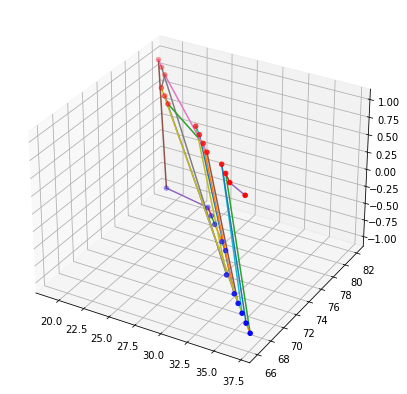

In [8]:
# %matplotlib widget
%matplotlib inline


"""
move visualization
"""

sequence = 'UUGUACUAUAAUGGUGAGGGUUCGGCACUAUGGCGUGUGUUCAGUUAAUAAAGGGUACUGUAAUUCCGCGUGGACGGCGCCUCUCGCAUGCUAUUUAAAG'
s1       = '.............((((((....(((.((.(.(((((.(((((((...........)))).)))..))))).)..)).))))))))).............'
s2       = '.............(((((((((((...((((.(((.(.(((((((...........)))).))).)))))))).))).))).))))).............'

fc = RNA.fold_compound(sequence)
pt1 = RNA.ptable(s1)
pt2 = RNA.ptable(s2)

move_list = []
move_list_vis = []

for i in range(1, len(sequence)+1):
    if (pt1[i] != pt2[i]):
        if (i < pt1[i]):
            # /* need to delete this pair */
            # // move_list.push_back(0);
            move_list.append((-i, -pt1[i]))
            move_list_vis.append((i, pt1[i], -1))
            bp_dist =+ 1

        if (i < pt2[i]):
            # /* need to insert this pair */
            # // move_list.push_back(0);
            move_list.append((i, pt2[i]))
            move_list_vis.append((i, pt2[i], 1))
            bp_dist =+ 1


move_list_vis = np.array(move_list_vis)

move_list_vis = move_list_vis.T
i0 = np.where(move_list_vis[2] == -1)[0] # Fraction 0: Iris-setosa
i1 = np.where(move_list_vis[2] == 1)[0] # Fraction 1: Iris-versicolor
move_list_vis = move_list_vis.T

fig = plt.figure(figsize = (10,7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(move_list_vis[:,0][i0], move_list_vis[:,1][i0], move_list_vis[:,2][i0], color='blue', label='Iris setosa') # scatter plot fraction 0 Iris-setosa
ax.scatter(move_list_vis[:,0][i1], move_list_vis[:,1][i1], move_list_vis[:,2][i1], color='red', label='Iris versicolor')  # scatter plot Fraction 1: Iris-versicolor


# samples = np.stack([data[0], data[1], data[2], np.ones_like(data[0])], axis=1)
# move_list_vis
# move_list_vis


# connect points as the path tells us
for n in range(len(path)-2):

    i1, j1, _ = path[n+1]
    i2, j2, _ = path[n+2]

    if i1 < 0: # delete move 1
        k1 = -1
        i1, j1 = -i1, -j1
    else:
        k1 = 1

    if i2 < 0: # delete move 2
        k2 = -1
        i2, j2 = -i2, -j2
    else:
        k2 = 1

    # xvalues, yvalues, zvalues
    ax.plot((i1, i2), (j1, j2), (k1, k2))

    # print (i1, j1, k1, i2, j2, k2)
    # break


# ax.arrow(0, 0, 0.6, 0.7, head_width = 0.05, 
#          head_length = 0.1)